<a href="https://colab.research.google.com/github/youcefpy/pytorch-learning/blob/main/CNN_pyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# transform MNIST images to tensors of 4 Dimesions (images,Heigthn,with, color chanel )
transform = transforms.ToTensor()


In [ ]:
# Train data
train_data = datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)
train_data

100%|██████████| 9912422/9912422 [00:00<00:00, 75505988.15it/s]

Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42683472.10it/s]

Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20268902.45it/s]

Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22203413.48it/s]


Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
#test data
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)


In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
#create a small batch size of images
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [ ]:
#define the CNN model
#describe the convoluioanl layer and what it is doing (2 convolutional layers)
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [ ]:
#Grab one NMIST RECORD
for i, (X_train,y_train) in enumerate(train_data):
  break

conv1

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
X_train.shape
x = X_train.view(1,1,28,28)

In [ ]:
x = F.relu(conv1(x))

In [ ]:
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
#pooling 2d
x = F.max_pool2d(x,2,2)

In [ ]:
x.shape

torch.Size([1, 6, 13, 13])

In [ ]:
#second convolutional layer
x = F.relu(conv2(x))


In [ ]:
x.shape

torch.Size([1, 16, 11, 11])

In [ ]:
x = F.max_pool2d(x,2,2)

In [ ]:
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,12,3,1)
    #Fully conected layer
    self.fc1 = nn.Linear(300,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(X.size(0), -1) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)



In [ ]:
#create an instance of the model
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [ ]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=300, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
train_loader

In [ ]:
#Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
import time
start_time = time.time()
from tqdm import tqdm

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in tqdm(range(epochs)):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # # Print out some results
    # if b%600 == 0:
    #   print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')


100%|██████████| 5/5 [02:05<00:00, 25.04s/it]

Training Took: 2.087068271636963 minutes!


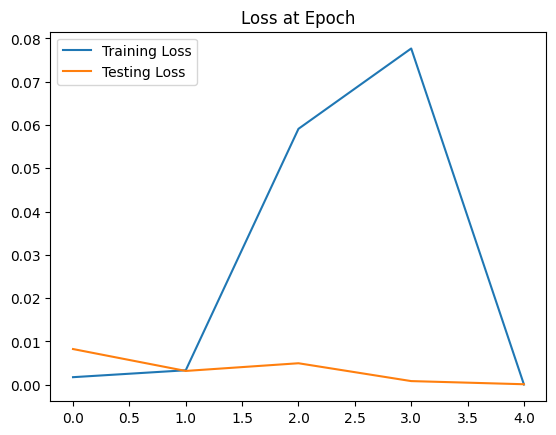

In [ ]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Testing Loss")
plt.title("Loss at Epoch")
plt.legend()

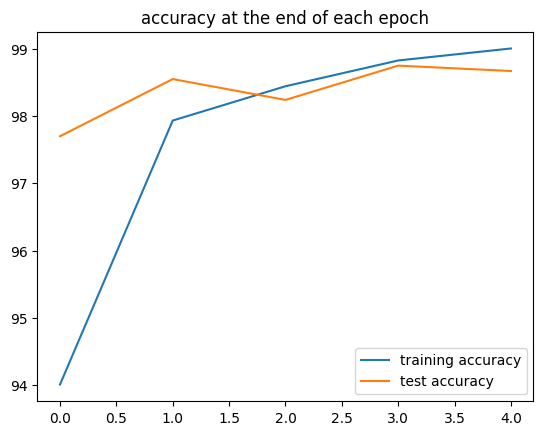

In [ ]:
plt.plot([t/600 for t in train_correct ],label="training accuracy")
plt.plot([t/100 for t in test_correct], label = "test accuracy")
plt.title('accuracy at the end of each epoch')
plt.legend()

In [ ]:
test_load_ = DataLoader(test_data,batch_size =100000,shuffle=False)

In [ ]:
with torch.no_grad():
  correct =0
  for b,(X_test,y_test) in  enumerate(test_load_):
    y_val = model(X_test)
    predected = torch.max(y_val.data, 1)[1]
    correct += (predected == y_test).sum()

In [ ]:
correct.item()/len(test_data) *100

98.67